In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import matplotlib.patches
from scipy.stats import zscore
from sklearn.decomposition import NMF, PCA

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

# Exploratory Data Analysis

## Loading the data

We are going to use `pickle` to load the DataFrame's we are going to work with. For this example we are only going to load and look at mouse set 1 data (`mouse_set_1_data.pkl`), but everything we do with this mouse set is the same for the other mouse set.

In [2]:
# Make sure the file is within the same directory, or you know the path to the mouse set 1 data
with open('data/mouse_set_1_data.pkl', 'rb') as handle:
    mouse_set_1 = pickle.load(handle) 
with open('data/mouse_set_2_data.pkl', 'rb') as handle:
    mouse_set_2 = pickle.load(handle) 

In [6]:
mouse_set_1.keys()

dict_keys(['reads', 'qpcr', 'times', 'otu_taxonomy'])

## Structure of the mouse set objects

The object `mouse_set_1` that you just loaded is a _dict_ object with four different entries:
1. `'reads'`
   * This key maps to the raw count data of each mouse that was outputted by [DADA2](https://github.com/benjjneb/dada2).


2. `'qpcr'`
   * This key maps to the qpcr (total abundance) data for each day for each mouse.

4. `'otu_taxonomy'`
   * This is a table that tells you the (approximate) taxonomy for each of the OTUs in the list as well as the 16S rRNA sequence that was used to barcode the OTU.
   
5. `'times'`
   * This is a _list_ object that converts the string time into a float time. More explanation will be below.
   

In [3]:
reads = mouse_set_1['reads']
qpcr = mouse_set_1['qpcr']
otu_taxonomy = mouse_set_1['otu_taxonomy']
times = mouse_set_1['times']

reads2 = mouse_set_2['reads']
qpcr2 = mouse_set_2['qpcr']
otu_taxonomy2 = mouse_set_2['otu_taxonomy']
times2 = mouse_set_2['times']

In [110]:
reads.keys()

dict_keys(['10', '6', '7', '8', '9'])

In [111]:
reads['7'].shape

(176, 73)

The objects `reads` and `qpcr` are _dict_'s as well. The dictionary maps the mouse ID (i.e. `'2'` for mouse 2) to the Pandas DataFrame that holds the respective data. So typing `reads['2']` will give us the DataFrame for the count data for mouse 2. 

`otu_taxonomy` is just a DataFrame because we assume that the OTU's between each mouse in a mouse set are consistent - so there is no reason to differentiate between each mouse.

`times` is a list that converts the _str_ labels of the days to the _float_ equivalent. For example: `'1'` -> `1.0`, `2AM`-> `2.0`, `2PM`->`2.5`. Here is what `times` looks like compared to the _str_ version:

In [8]:
print('float version:\n{}\n\nstr version:\n{}'.format(times, list(reads['2'].columns)))

float version:
[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 14.0, 16.0, 18.0, 21.0, 21.5, 22.0, 22.5, 23.0, 23.5, 24.0, 25.0, 28.0, 29.0, 29.5, 30.0, 30.5, 31.0, 31.5, 32.0, 33.0, 35.0, 35.5, 36.0, 36.5, 37.0, 38.0, 39.0, 42.0, 42.5, 43.0, 43.5, 44.0, 44.5, 45.0, 45.5, 46.0, 47.0, 50.0, 50.5, 51.0, 51.5, 52.0, 52.5, 53.0, 54.0, 57.0, 57.5, 58.0, 58.5, 59.0, 59.5, 60.0, 60.5, 61.0, 62.0, 63.0, 64.0, 64.5]

str version:
['0AM', '0PM', '1AM', '1PM', '2AM', '2PM', '3AM', '3PM', '4AM', '4PM', '5', '6', '7', '8', '9', '10', '11', '14', '16', '18', '21AM', '21PM', '22AM', '22PM', '23AM', '23PM', '24', '25', '28AM', '29AM', '29PM', '30AM', '30PM', '31AM', '31PM', '32', '33', '35AM', '35PM', '36AM', '36PM', '37AM', '38', '39', '42AM', '42PM', '43AM', '43PM', '44AM', '44PM', '45AM', '45PM', '46', '47', '50AM', '50PM', '51AM', '51PM', '52AM', '52PM', '53', '54', '57AM', '57PM', '58AM', '58PM', '59AM', '59PM', '60AM', '60PM', '61', '62', '63', '64AM', '64

****
Let's take a look at the first 10 OTU's in reads for mouse 2:

In [98]:
reads.keys()

dict_keys(['2', '3', '4', '5'])

In [114]:
reads2['10'][:10]

,0AM,1AM,1PM,2AM,2PM,3AM,3PM,4AM,4PM,5,...,58PM,59AM,59PM,60AM,60PM,61,62,63,64AM,64PM
OTU_1,21,17840,16906,14523,17671,15752,18842,14836,15765,15508,...,7746,10309,8718,20313,15467,13528,12165,14840,15672,33296
OTU_2,16,6500,7689,11197,16005,13070,13273,12820,15126,14831,...,17655,6335,14515,9696,16228,8515,9296,3355,8284,15183
OTU_3,4,47,1081,13058,20855,15946,22863,21204,16417,10974,...,14,23,21,235,2263,6679,7738,2616,10542,19405
OTU_4,3,0,0,3,0,0,16,6,0,0,...,47,11,84,52,50,34,45,3574,34,56
OTU_5,3,2,3,7,4,16,11,14,4,10,...,0,0,0,0,5,2,0,2,1,0
OTU_6,0,0,26,208,492,744,348,70,156,639,...,2224,4167,6414,7830,6997,3546,5602,6345,4070,9921
OTU_7,0,919,1224,1984,2904,2404,2223,2445,2831,2558,...,671,309,755,339,754,330,364,1540,278,574
OTU_8,13,383,453,245,240,117,147,172,161,280,...,3967,1314,2791,1997,3420,1906,1994,615,1762,3405
OTU_9,0,10082,6959,4349,4750,3162,3970,3039,4220,2703,...,4551,1493,2830,1345,1781,713,1635,636,1036,2771
OTU_10,2,2731,1757,780,682,319,476,575,648,878,...,2528,505,2119,427,1451,183,186,655,450,1102


In [19]:
reads['2'][:10]

,0AM,0PM,1AM,1PM,2AM,2PM,3AM,3PM,4AM,4PM,...,58PM,59AM,59PM,60AM,60PM,61,62,63,64AM,64PM
OTU_1,1094,3292,1744,193,468,974,1323,2854,7106,3949,...,3297,1415,1539,1641,6409,1477,1108,573,841,762
OTU_2,180,825,1340,4501,9959,5564,2738,3069,2318,1229,...,100,25,0,80,5359,86,398,447,1265,1326
OTU_3,10,8,10,27,117,28,44,50,77,49,...,10,6,3,20,15,26,11,4,7,24
OTU_4,3,0,9,32,205,254,196,361,1073,871,...,7318,6252,8405,9322,9061,12263,10940,6070,9832,8101
OTU_5,6,13,195,517,744,4703,5620,8592,11602,11978,...,1,0,0,0,4,1,1,8,1,0
OTU_6,0,0,2,6,71,78,863,1069,2275,2079,...,5345,3932,2191,5408,7225,6089,2896,4248,3997,2406
OTU_7,67,173,810,2376,5607,3418,1634,2004,1417,803,...,5345,2807,2672,2568,3401,3711,3641,2050,3343,3232
OTU_8,44,49,712,2685,8251,7763,6387,10253,17630,10625,...,0,0,0,0,136,0,0,0,0,0
OTU_9,178,728,0,20,48,9,10,13,8,14,...,0,0,0,0,426,0,0,0,0,0
OTU_10,206,154,3989,8257,3508,1784,1020,1550,1216,790,...,285,253,301,597,1355,1283,1531,789,1686,1854


You can see that the columns are already ordered in time and each row corresponds to a different OTU. 

What's the taxonomy for `'OTU_1'`?

In [7]:
otu_taxonomy.loc['OTU_1']

sequence    TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...
Kingdom                                              Bacteria
Phylum                                          Bacteroidetes
Class                                             Bacteroidia
Order                                           Bacteroidales
Family                                         Bacteroidaceae
Genus                                             Bacteroides
Name: OTU_1, dtype: object

You know what? Let's look at the taxonomies for each of the first 10 OTU's.

In [115]:
otu_taxonomy2[:10]

,sequence,Kingdom,Phylum,Class,Order,Family,Genus
otuName,,,,,,,
OTU_1,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides
OTU_2,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides
OTU_3,TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTG...,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Verrucomicrobiaceae,Akkermansia
OTU_4,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides
OTU_5,TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTG...,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Verrucomicrobiaceae,Akkermansia
OTU_6,TACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGGGTG...,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Sutterellaceae,Parasutterella
OTU_7,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides
OTU_8,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides
OTU_9,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides


In [52]:
otu_taxonomy[:10]

,sequence,Kingdom,Phylum,Class,Order,Family,Genus
otuName,,,,,,,
OTU_1,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides
OTU_2,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides
OTU_3,TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTG...,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Verrucomicrobiaceae,Akkermansia
OTU_4,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides
OTU_5,TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTG...,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Verrucomicrobiaceae,Akkermansia
OTU_6,TACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGGGTG...,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Sutterellaceae,Parasutterella
OTU_7,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides
OTU_8,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides
OTU_9,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides


There are a lot of _Bacteroides_...

****

Since DataFrame's are so powerful, we can plot the count data straight from the DataFrame. `.plot` plots the index (row) against every column. Since we want to plot the column against every index, we should trasponse the dataframe with `.T`.

Let's plot the reads for the first 5 OTU's for mouse 2:

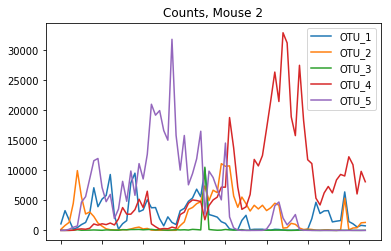

In [13]:
reads['2'][:5].T.plot(kind='line', title='Counts, Mouse 2')

This might look good at first, but remember that our samples have irregular time spacing, so our x-axis is not spaced correctly (DataFrame assumes regular spacing). We can use our `times` array to tell us where to place each of the points (I could not figure out how to adjust the separation within the DataFrame so I'm using `matplotlib`. If you figure out how to do it please tell me).

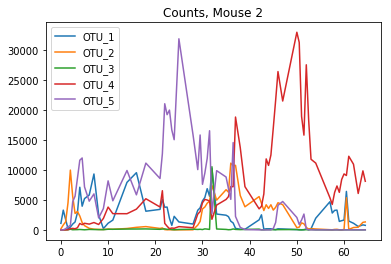

In [14]:
plt.figure()
temp = reads['2'][:5].values # Get our counts for the first 5 OTUs
for i in range(5):
    plt.plot(times, temp[i], label=reads['2'].index[i])
plt.title('Counts, Mouse 2')
plt.legend()

Even though these might look similar, there are slight differences. You can see it in the skew for the peaks in `'OTU_5'` and `'OTU_4'`.

Let's now look at the qPCR data in `qpcr`:

In [15]:
# For consistency let's stay with mouse 2
qpcr['2'][:10]

,mean,std
0AM,8.724134e+06,6.029776e+05
0PM,3.674454e+07,1.388925e+07
1AM,2.554379e+11,9.572197e+10
1PM,8.266330e+09,2.948702e+09
2AM,8.107457e+09,4.296630e+09
2PM,1.905142e+10,3.322286e+09
3AM,1.811374e+10,5.234633e+09
3PM,6.111956e+10,1.666324e+10
4AM,6.602661e+10,1.617742e+10
4PM,3.331552e+10,1.106133e+10


The rows correspond to the days, and we have `'mean'` and `'std'` (standard deviation) as the columns.

Let's plot the total bacterial load over time:

Text(0.5, 1.0, 'Mouse 2 bacterial load')

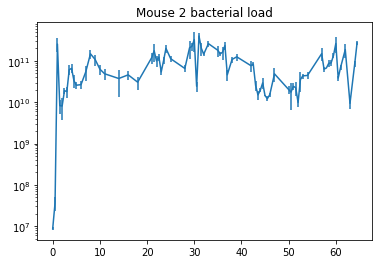

In [16]:
plt.figure()
y = list(qpcr['2']['mean'])
yerr = list(qpcr['2']['std'])
plt.errorbar(times, y, yerr=yerr)
plt.yscale('log')
plt.title('Mouse 2 bacterial load')

We can even plot bacterial load for all of the mice!

Text(0.5, 1.0, 'Mouse set 1 bacterial load')

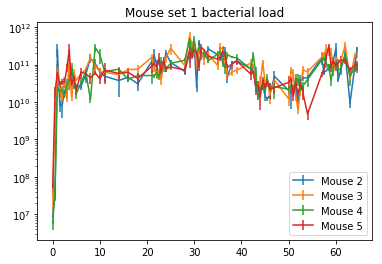

In [17]:
plt.figure()
for mid,df in qpcr.items():
    y = df['mean']
    yerr = df['std']
    plt.errorbar(times, y, yerr=yerr, label= 'Mouse {}'.format(mid))
plt.yscale('log')
plt.legend()
plt.title('Mouse set 1 bacterial load')

We can also plot the counts of `'OTU_1'` over all the mice:

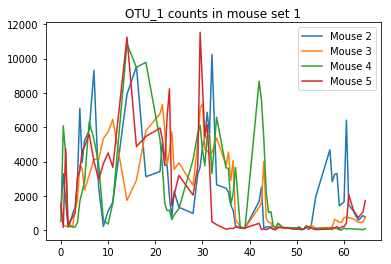

In [18]:
plt.figure()
for mid, df in reads.items():
    y = df.loc['OTU_1']
    plt.plot(times, y, label='Mouse {}'.format(mid))
plt.title('OTU_1 counts in mouse set 1')
plt.legend()
    

We already saw how to extract relative counts of each OTU and the total bacteria load for every time point. To obtain the absolute abundance of each OTU, we can multiply these two values. For instance, this is the results of OTU_1 of mouse 2:
#### (1) The relative aboundance

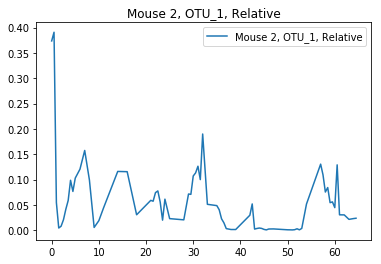

In [21]:
m2_reads_values=reads['2'].values
m2_reads_values_sum=sum(m2_reads_values)
m2_OTU_1_reads=reads['2'].loc['OTU_1']
m2_relative_abundance_OTU_1=m2_OTU_1_reads.values/m2_reads_values_sum

plt.figure()
plt.plot(times, m2_relative_abundance_OTU_1, label='Mouse 2, OTU_1, Relative')
plt.title('Mouse 2, OTU_1, Relative')
plt.legend()


#### (2) The absolute aboundance

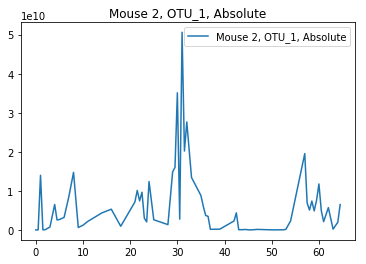

In [26]:
m2_total_amount = qpcr['2']['mean'].values
m2_abs_abundance_OTU_1 = m2_relative_abundance_OTU_1 * m2_total_amount

plt.figure()
plt.plot(times, m2_abs_abundance_OTU_1, label='Mouse 2, OTU_1, Absolute')
plt.title('Mouse 2, OTU_1, Absolute')
plt.legend()

We can look at abundance of each OTU by naively averaging across time. In the example of mouse 2, the abundance seems to be roughly exponentially decayed as the id number of OTU increased, meaning that the population sizes of different bacteria is very disproportionate.

/Users/shihyitseng/anaconda3/envs/109b/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Abundance of OTUs (average across time)')

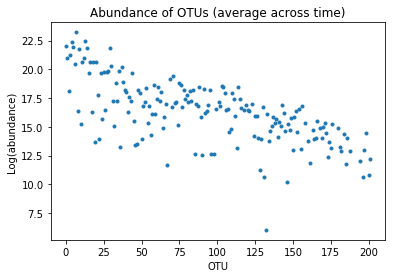

In [141]:
plt.plot(np.log(np.mean(m_all_abs_amount[:,:21], axis =1)),'.')
plt.xlabel('OTU')
plt.ylabel('Log(abundance)')
plt.title('Abundance of OTUs (average across time)')

If we directly plot the abundance of all OTU as time series, we can see changes of abundance across time. The three shadow areas correspond to the periods of high fat diet, Gram positive antibiotics and Gram negative antibiotics, respectively.

In [4]:
high_fat = [21.5,28.5]
gram_pos = [35.5,42.5]
gram_neg = [50.5,57.5]
pertubation = high_fat.copy()
pertubation.extend(gram_pos)
pertubation.extend(gram_neg)

In [5]:
from scipy.stats import zscore
mouse_id = '2'
mouse_reads_df = reads[mouse_id]
m_total_amount = qpcr[mouse_id]['mean'].values
all_OTU = list(mouse_reads_df.index)

m_reads_values=reads[mouse_id].values
m_reads_values_sum=sum(m_reads_values)

m_all_abs_amount = np.zeros((len(all_OTU), len(times)))
for idx, otu in enumerate(all_OTU):
    these_reads = mouse_reads_df.loc[otu]
    this_relative_abundance = these_reads.values/m_reads_values_sum
    this_abs_abundance = this_relative_abundance * m_total_amount
    
    m_all_abs_amount[idx,:] = this_abs_abundance
    
m_all_abs_amount_z = zscore(m_all_abs_amount, axis = 1)

In [16]:
m_total_amount.shape

(75,)

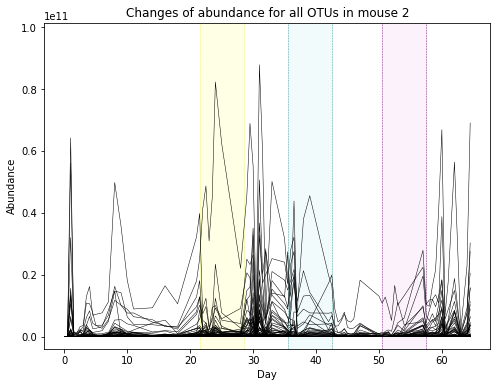

In [12]:
fig,ax = plt.subplots(1,1,figsize = (8,6))
ax.plot(times, m_all_abs_amount.T, linewidth = 0.5, c='k');

y1,y2 = ax.get_ylim()
ax.vlines(x = high_fat, ymin = y1*0.9, ymax = y2*1.1, color = 'yellow', linewidth = 0.5, linestyle = '--')
ax.vlines(x = gram_pos, ymin = y1*0.9, ymax = y2*1.1, color = 'c', linewidth = 0.5, linestyle = '--')
ax.vlines(x = gram_neg, ymin = y1*0.9, ymax = y2*1.1, color = 'm', linewidth = 0.5, linestyle = '--')

rect1 = matplotlib.patches.Rectangle((high_fat[0],y1*0.9), high_fat[1]-high_fat[0],y2*1.1-y1*0.9, 
                                     color='yellow',alpha = 0.1)
rect2 = matplotlib.patches.Rectangle((gram_pos[0],y1*0.9), gram_pos[1]-gram_pos[0],y2*1.1-y1*0.9, 
                                     color='c',alpha = 0.05)
rect3 = matplotlib.patches.Rectangle((gram_neg[0],y1*0.9), gram_neg[1]-gram_neg[0],y2*1.1-y1*0.9, 
                                     color='m',alpha = 0.05)
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)
ax.set_ylim([y1*0.9, y2*1.1])
ax.set(xlabel='Day', ylabel = 'Abundance', title = 'Changes of abundance for all OTUs in mouse 2');

## Components of the time-series

To explore if there are subgroups/modes of bacteria that covaried across time, we can factorize the time series data into several factors. We chose non-negative matrix factorization (NMF) instead of PCA because the number of bacteria is always positive, and there’s also no reason to impose the orthogonality between factors as PCA does. Here are the temporal profiles of each factors using different number of factors. We can already see that different factors rose and fell at various time points, with some corresponding to the onsets or offsets of the perturbations (which was not imposed a priori). Here we did not scale the data since the relative abundance of each OTU might be an important aspect. If we normalize across each OTU, we might be amplifying noise since a large number of OTUs only consist a really small portion of the whole microbiome.

In [102]:
from sklearn.decomposition import NMF, PCA
n_comp = 5
model = PCA(n_components = n_comp)
score = model.fit_transform(m_all_abs_amount.T)
PC = model.components_

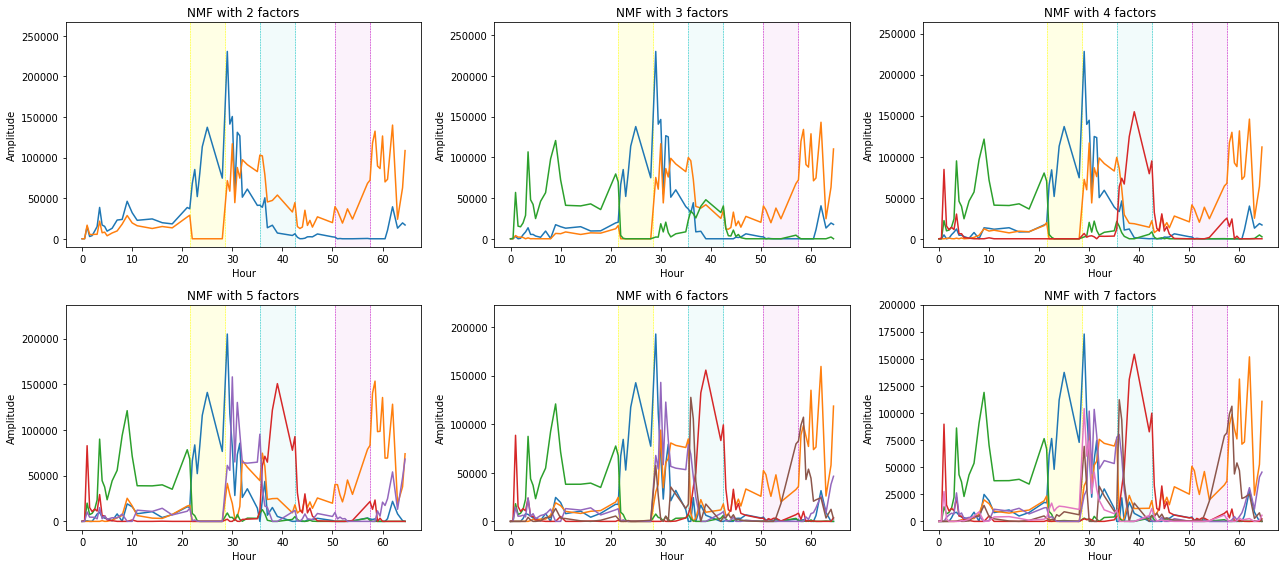

In [274]:
fig,ax = plt.subplots(2,3,figsize = (18,8))

for i in range(6):
    n_comp = i+2
    model = NMF(n_components = n_comp)
    score = model.fit_transform(all_abs_amount.T)
    PC = model.components_

    ax[i//3,i%3].plot(times, score);
    y1,y2 = ax[i//3,i%3].get_ylim()
    ax[i//3,i%3].vlines(x = high_fat, ymin = y1*0.9, ymax = y2*1.1, color = 'yellow', linewidth = 0.5, linestyle = '--')
    ax[i//3,i%3].vlines(x = gram_pos, ymin = y1*0.9, ymax = y2*1.1, color = 'c', linewidth = 0.5, linestyle = '--')
    ax[i//3,i%3].vlines(x = gram_neg, ymin = y1*0.9, ymax = y2*1.1, color = 'm', linewidth = 0.5, linestyle = '--')

    rect1 = matplotlib.patches.Rectangle((high_fat[0],y1*0.9), high_fat[1]-high_fat[0],y2*1.1-y1*0.9, 
                                         color='yellow',alpha = 0.1)
    rect2 = matplotlib.patches.Rectangle((gram_pos[0],y1*0.9), gram_pos[1]-gram_pos[0],y2*1.1-y1*0.9, 
                                         color='c',alpha = 0.05)
    rect3 = matplotlib.patches.Rectangle((gram_neg[0],y1*0.9), gram_neg[1]-gram_neg[0],y2*1.1-y1*0.9, 
                                         color='m',alpha = 0.05)
    ax[i//3,i%3].add_patch(rect1)
    ax[i//3,i%3].add_patch(rect2)
    ax[i//3,i%3].add_patch(rect3)
    ax[i//3,i%3].set(ylim=[y1*0.9, y2*1.1], title = 'NMF with {} factors'.format(n_comp), 
                     xlabel = 'Hour', ylabel = 'Amplitude')
plt.tight_layout()

From the plots above, we found 5 factors are sufficeint to show the temporal changes:

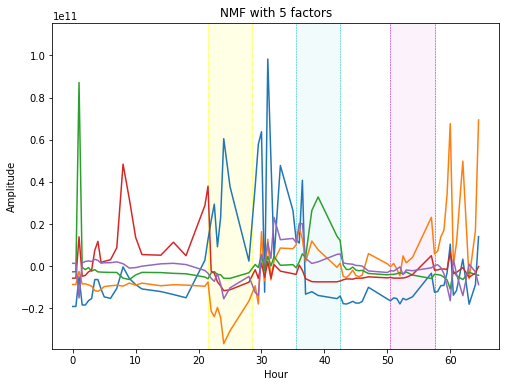

In [103]:
fig,ax = plt.subplots(1,1,figsize = (8,6))
ax.plot(times, score);
y1,y2 = ax.get_ylim()
ax.vlines(x = high_fat, ymin = y1*0.9, ymax = y2*1.1, color = 'yellow', linewidth = 0.5, linestyle = '--')
ax.vlines(x = gram_pos, ymin = y1*0.9, ymax = y2*1.1, color = 'c', linewidth = 0.5, linestyle = '--')
ax.vlines(x = gram_neg, ymin = y1*0.9, ymax = y2*1.1, color = 'm', linewidth = 0.5, linestyle = '--')

rect1 = matplotlib.patches.Rectangle((high_fat[0],y1*0.9), high_fat[1]-high_fat[0],y2*1.1-y1*0.9, 
                                     color='yellow',alpha = 0.1)
rect2 = matplotlib.patches.Rectangle((gram_pos[0],y1*0.9), gram_pos[1]-gram_pos[0],y2*1.1-y1*0.9, 
                                     color='c',alpha = 0.05)
rect3 = matplotlib.patches.Rectangle((gram_neg[0],y1*0.9), gram_neg[1]-gram_neg[0],y2*1.1-y1*0.9, 
                                     color='m',alpha = 0.05)
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)


ax.set(ylim=[y1*0.9, y2*1.1], title = 'NMF with {} factors'.format(n_comp), 
       xlabel = 'Hour', ylabel = 'Amplitude');

We can inspect the composition of each factor by looking at the score of every
OTU. Here is an example of the NMF with 4 factors, showing only scores of the first 20
OTUs.

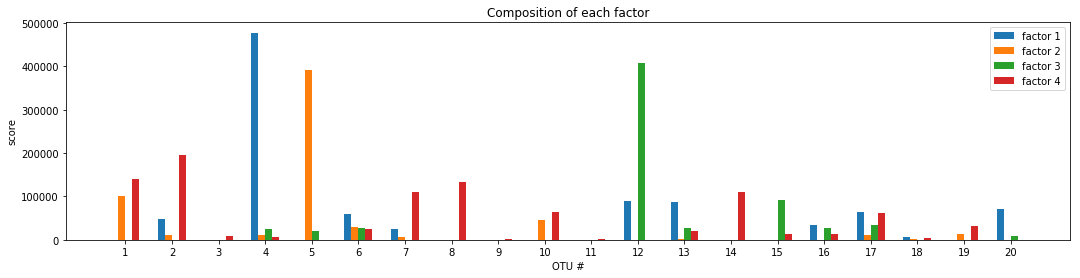

In [287]:
fig,ax = plt.subplots(1,1,figsize = (18,4))
for i in range(n_comp):
    plt.bar(np.arange(1,21)+(i-n_comp/2+0.5)*0.15,PC[i,:20], width=0.15,label = 'factor {}'.format(i+1))
plt.legend()
ax.set(xticks = np.arange(1,21), xlabel='OTU #', ylabel = 'score', title='Composition of each factor');

We found the scores of factors is a good measurement describing the temporal profile of OTUs, thus we decided to perform clustering based on how these scores are similar to each other.